In [0]:
from fastai import *
from fastai.tabular import *
import pandas as pd
from torchsummary import summary
import torch
from torch import nn
import imageio
import torch
import glob
from fastai.vision import *
import os
from torch import nn
import torch.nn.functional as F

In [2]:
colab = True
if colab:
  from google.colab import drive
  drive.mount('/content/drive', force_remount = True)
  %cp "/content/drive/My Drive/autoencoder-training/data.zip" .
  !unzip -q data.zip
  image_path = "data"
else: 
  os.chdir("../")
  image_path = os.getcwd() + "/data"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
np.random.seed(3333)
torch.manual_seed(3333)

size = 32
batchsize = 128

tfms = get_transforms(do_flip = True)
src = (ImageImageList.from_folder(image_path).split_by_folder().label_from_func(lambda x: x))
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=batchsize)
        .normalize(imagenet_stats, do_y = False))


# Model

In [0]:
class AdaptiveConcatPool2d(Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self, sz:Optional[int]=None):
        "Output will be 2*sz or 2 if sz is None"
        self.output_size = sz or 1
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)

    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[0:8]))
        for param in resnet.parameters():
            param.requires_grad = False

        self.encoder = nn.Sequential(resnet, AdaptiveConcatPool2d())

    def encode(self, x): return self.encoder(x)

    def forward(self, x):
      encoded = self.encoder(x)
      return encoded

In [0]:
def icnr(x, scale=2, init=nn.init.kaiming_normal_):
    "ICNR init of `x`, with `scale` and `init` function."
    ni,nf,h,w = x.shape
    ni2 = int(ni/(scale**2))
    k = init(torch.zeros([ni2,nf,h,w])).transpose(0, 1)
    k = k.contiguous().view(ni2, nf, -1)
    k = k.repeat(1, 1, scale**2)
    k = k.contiguous().view([nf,ni,h,w]).transpose(0, 1)
    x.data.copy_(k)

class PixelShuffle_ICNR(nn.Module):
    "Upsample by `scale` from `ni` filters to `nf` (default `ni`), using `nn.PixelShuffle`, `icnr` init, and `weight_norm`."
    def __init__(self, ni:int, nf:int=None, scale:int=2, blur:bool=False, norm_type=NormType.Weight, leaky:float=None):
        super().__init__()
        nf = ifnone(nf, ni)
        self.conv = conv_layer(ni, nf*(scale**2), ks=1, norm_type=norm_type, use_activ=False)
        icnr(self.conv[0].weight)
        self.shuf = nn.PixelShuffle(scale)
        # Blurring over (h*w) kernel
        # "Super-Resolution using Convolutional Neural Networks without Any Checkerboard Artifacts"
        # - https://arxiv.org/abs/1806.02658
        self.pad = nn.ReplicationPad2d((1,0,1,0))
        self.blur = nn.AvgPool2d(2, stride=1)
        self.relu = relu(True, leaky=leaky)

    def forward(self,x):
        x = self.shuf(self.relu(self.conv(x)))
        return self.blur(self.pad(x)) if self.blur else x

In [0]:
test_tens = torch.randn([32, 3, 32, 32])

In [7]:
test_tens = Encoder()(test_tens)

Downloading: "https://github.com/pytorch/vision/archive/v0.5.0.zip" to /root/.cache/torch/hub/v0.5.0.zip
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [8]:
test_tens.shape

torch.Size([32, 1024, 1, 1])

In [0]:
test_tens = PixelShuffle_ICNR(1024, 512, scale=2, blur = True)(test_tens)

In [10]:
test_tens.shape

torch.Size([32, 512, 2, 2])

In [0]:
class Upsample1(nn.Module):
  def __init__(self, in_:int, out:int, scale:int=2, blur:bool=True):
    super().__init__()
    self.pixel_shuffle = PixelShuffle_ICNR(in_, out, scale, blur)
    self.bn = nn.BatchNorm2d(out, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.conv1 = nn.Sequential(
            nn.Conv2d(out, out, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(out, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
    )
    self.conv2 = nn.Sequential(
            nn.Conv2d(out, out, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(out, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
    )

  def forward(self, x):
    x = self.pixel_shuffle(x)
    x = self.bn(x)
    x = self.conv1(x)
    x = self.conv2(x)
    return x


class Upsample2(nn.Module):
  def __init__(self, in_:int, out:int, scale:int=2, blur:bool=True):
    super().__init__()
    self.pixel_shuffle = PixelShuffle_ICNR(in_, out, scale, blur)
    self.bn = nn.BatchNorm2d(out, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.conv1 = nn.Sequential(
            nn.Conv2d(out, out, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(out, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
    )

  def forward(self, x):
    x = self.pixel_shuffle(x)
    x = self.bn(x)
    x = self.conv1(x)
    return x

class Upsample3(nn.Module):
  def __init__(self, in_:int, out:int, scale:int=2, blur:bool=True):
    super().__init__()
    self.pixel_shuffle = PixelShuffle_ICNR(in_, out, scale, blur)
    self.bn = nn.BatchNorm2d(out, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  def forward(self, x):
    x = self.pixel_shuffle(x)
    x = self.bn(x)
    return x

In [0]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.up1 = Upsample1(1024, 512, scale = 2, blur = True)
        self.up2 = Upsample1(512, 256, scale = 2, blur = True)
        self.up3 = Upsample1(256, 128, scale = 2, blur = True)
        self.up4 = Upsample1(128, 64, scale = 2, blur = True)
        self.up5 = Upsample1(64, 3, scale = 2, blur = True)


        self.decoder = nn.Sequential(Upsample1(1024, 512, scale = 2, blur = True), 
                                     Upsample1(512, 256, scale = 2, blur = True),
                                     Upsample1(256, 128, scale = 2, blur = True),
                                     Upsample1(128, 64, scale = 2, blur = True),
                                     Upsample1(64, 3, scale = 2, blur = True),
        )

    def decode(self, x): return self.decoder(x)

    def forward(self, x):
      x = self.up1(x)
      x = self.up2(x)
      x = self.up3(x)
      x = self.up4(x)
      x = self.up5(x)
      return x

In [0]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()

    def encode(self,x): return self.encoder(x)
    def decode(self,x): return self.decoder(x)

    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(x)
      return decoded #torch.clamp(decoded, min=0, max = 1)

In [95]:
ae = Autoencoder()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


In [104]:
tens[0].shape

torch.Size([128, 3, 32, 32])

In [102]:
Decoder()(Encoder()(tens[0])).shape

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


torch.Size([128, 3, 32, 32])

In [0]:
learn = Learner(data, ae, loss_func=F.mse_loss);

In [98]:
data

ImageDataBunch;

Train: LabelList (50000 items)
x: ImageImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
Path: data;

Valid: LabelList (10000 items)
x: ImageImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
Path: data;

Test: None

In [97]:
learn.summary()

RuntimeError: ignored

In [0]:
test_tens = torch.randn([32, 3, 32, 32]).cuda()

In [55]:
test_tens = ae.encode(test_tens)
test_tens.shape

torch.Size([32, 1024, 1, 1])

In [56]:
test_tens = ae.decode(test_tens)
test_tens.shape

torch.Size([32, 3, 32, 32])

In [58]:
ae(test_tens)

RuntimeError: ignored

In [106]:
test_tens = ae.forward(test_tens)

RuntimeError: ignored

In [71]:
ae.decoder.decoder[1](ae.decoder.decoder[0](test_tens)).shape

torch.Size([32, 256, 4, 4])

In [72]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,time


RuntimeError: ignored

In [73]:
test_tens.shape

torch.Size([32, 1024, 1, 1])

In [75]:
ae.decoder(test_tens).shape

torch.Size([32, 3, 32, 32])

In [0]:
tens = data.one_batch()

In [80]:
tens[0].shape

torch.Size([128, 3, 32, 32])

In [88]:
ae.decoder(ae.encoder(tens[0].cuda())).shape

torch.Size([128, 3, 32, 32])

In [0]:
tens2 = ae.encoder.encoder.forward(tens[0].cuda())

In [0]:
class Encoder1(nn.Module):
    def __init__(self):
        super(Encoder1, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[0:3]))
        for param in resnet.parameters():
            param.requires_grad = False

        self.encoder = nn.Sequential(resnet)

    def encode(self, x): return self.encoder(x)

    def forward(self, x):
      encoded = self.encoder(x)
      return encoded

class Encoder2(nn.Module):
    def __init__(self):
        super(Encoder2, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[3:5]))
        for param in resnet.parameters():
            param.requires_grad = False
        for i in range(len(resnet)):
            for param in resnet[1][i].bn1.parameters():
                param.requires_grad = True
            for param in resnet[1][i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(resnet)

    def encode(self, x): return self.encoder(x)

    def forward(self, x):
      encoded = self.encoder(x)
      return encoded

class Encoder3(nn.Module):
    def __init__(self):
        super(Encoder3, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[5]))
        for param in resnet.parameters():
            param.requires_grad = False
        for i in range(len(resnet)):
            for param in resnet[i].bn1.parameters():
                param.requires_grad = True
            if i== 0:
                for param in resnet[i].downsample[1].parameters():
                  param.requires_grad = True
            for param in resnet[i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(resnet)

    def encode(self, x): return self.encoder(x)

    def forward(self, x):
      encoded = self.encoder(x)
      return encoded

class Encoder4(nn.Module):
    def __init__(self):
        super(Encoder4, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[6]))
        for param in resnet.parameters():
            param.requires_grad = False
        for i in range(len(resnet)):
            for param in resnet[i].bn1.parameters():
                param.requires_grad = True
            if i== 0:
                for param in resnet[i].downsample[1].parameters():
                  param.requires_grad = True
            for param in resnet[i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(resnet)

    def encode(self, x): return self.encoder(x)

    def forward(self, x):
      encoded = self.encoder(x)
      return encoded

class Encoder5(nn.Module):
    def __init__(self):
        super(Encoder5, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[7]))
        for param in resnet.parameters():
            param.requires_grad = False
        for i in range(len(resnet)):
            for param in resnet[i].bn1.parameters():
                param.requires_grad = True
            if i== 0:
                for param in resnet[i].downsample[1].parameters():
                  param.requires_grad = True
            for param in resnet[i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(resnet)

    def encode(self, x): return self.encoder(x)

    def forward(self, x):
      encoded = self.encoder(x)
      return encoded

class AdaptiveConcatPool2d(Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self, sz:Optional[int]=None):
        "Output will be 2*sz or 2 if sz is None"
        self.output_size = sz or 1
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)

    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

class Encoder6(nn.Module):
    def __init__(self):
        super(Encoder6, self).__init__()

        self.encoder = nn.Sequential(AdaptiveConcatPool2d())

    def encode(self, x): return self.encoder(x)

    def forward(self, x):
      encoded = self.encoder(x)
      return encoded


In [0]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(Encoder1(), 
                                     Encoder2(), 
                                     Encoder3(), 
                                     Encoder4(), 
                                     Encoder5(), 
                                     Encoder6())

        self.decoder = nn.Sequential(Upsample1(1024, 512, scale = 2, blur = True), 
                                     Upsample1(512, 256, scale = 2, blur = True),
                                     Upsample1(256, 128, scale = 2, blur = True),
                                     Upsample1(128, 64, scale = 2, blur = True),
                                     Upsample1(64, 3, scale = 2, blur = True))

    def encode(self, x): return self.encoder(x)

    def decode(self,x): return torch.clamp(self.decoder(x), min = 0, max=1)

      
    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return torch.clamp(decoded, min = 0, max = 1)


In [112]:
ae = AutoEncoder()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


In [0]:
tens = torch.randn([128,3,32,32])

In [115]:
tens = ae.encode(tens)
tens.shape

torch.Size([128, 1024, 1, 1])

In [116]:
tens = ae.decode(tens)
tens.shape

torch.Size([128, 3, 32, 32])

In [0]:
learn = Learner(data, ae, loss_func = F.mse_loss)

In [118]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,time
0,0.040711,0.041592,02:09


In [119]:
learn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.59E-07
Min loss divided by 10: 6.31E-06


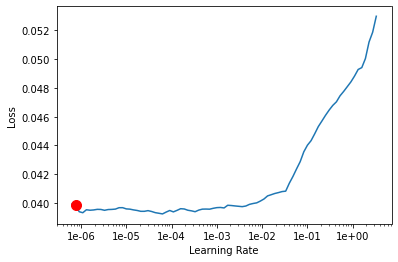

In [122]:
learn.recorder.plot(suggestion = True)

In [0]:
learn.fit_one_cycle(10, max_lr = 1e-03)

epoch,train_loss,valid_loss,time
0,0.038867,0.040613,02:08


In [0]:
learn.unfreeze()

In [0]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(Encoder1(), 
                                     Encoder2(), 
                                     Encoder3(), 
                                     Encoder4(), 
                                     Encoder5(), 
                                     Encoder6())

        self.decoder = nn.Sequential(Upsample2(1024, 512, scale = 2, blur = True), 
                                     Upsample2(512, 256, scale = 2, blur = True),
                                     Upsample2(256, 128, scale = 2, blur = True),
                                     Upsample2(128, 64, scale = 2, blur = True),
                                     Upsample2(64, 3, scale = 2, blur = True))

    def encode(self, x): return self.encoder(x)

    def decode(self,x): return torch.clamp(self.decoder(x), min = 0, max=1)

      
    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return torch.clamp(decoded, min = 0, max = 1)
